# Enhanced Demand Forecasting using XGBoost with Daily Data
This script performs demand forecasting using daily demand data combined with monthly economic indicators.

## Import Libraries and Load Data

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns   

# Load daily data
daily_df = pd.read_excel(
    r"C:\Users\k_pow\OneDrive\Documents\MIT\MITx SCM\IAP 2025\SCC\Customer Order Quantity_Dispatched Quantity.xlsx"
)

# Filter for Material_4
material_id = '000161032'  # Material_4
material_no = 'Material_4'
daily_df = daily_df[daily_df['Product ID'] == material_id].copy()

# Convert date column
daily_df['Date'] = pd.to_datetime(daily_df['Date'], format='%d.%m.%Y')
daily_df.set_index('Date', inplace=True)
daily_df.sort_index(inplace=True)

# Load monthly data with external variables
monthly_df = pd.read_csv(f'C:\\Users\\k_pow\\OneDrive\\Documents\\MIT\\MITx SCM\\IAP 2025\\SCC\\Data_files\\{material_id}_{material_no}.csv')
monthly_df['YearMonth'] = pd.to_datetime(monthly_df['YearMonth'])
monthly_df.set_index('YearMonth', inplace=True)

print("Data loaded successfully.")
print("Daily data shape:", daily_df.shape)
print("Monthly data shape:", monthly_df.shape)

Data loaded successfully.
Daily data shape: (920, 7)
Monthly data shape: (95, 11)


In [36]:
daily_df

,Product ID,Product Name,Customer Order Quantity,Dispatched Quantity,Year,Month,Day
Date,,,,,,,
2022-01-03,000161032,Material_4,0,120,2022,1,3
2022-01-04,000161032,Material_4,0,75,2022,1,4
2022-01-05,000161032,Material_4,0,51,2022,1,5
2022-01-06,000161032,Material_4,0,246,2022,1,6
2022-01-07,000161032,Material_4,0,40,2022,1,7
...,...,...,...,...,...,...,...
2024-11-28,000161032,Material_4,0,92,2024,11,28
2024-11-29,000161032,Material_4,0,110,2024,11,29
2024-11-30,000161032,Material_4,0,30,2024,11,30


In [37]:
# Create a complete date range from the minimum to the maximum date
full_date_range = pd.date_range(start='2022-01-01', end='2024-12-05', freq='D')

# Reindex the dataframe to include all dates, filling missing values with 0
daily_df = daily_df.reindex(full_date_range, fill_value=0)

# Re-add the static 'Product ID' and 'Product Name' since they remain constant
daily_df['Product ID'] = material_no  
daily_df['Product Name'] = material_id  

# Re-add Year, Month, Day columns
daily_df['Year'] = daily_df.index.year
daily_df['Month'] = daily_df.index.month
daily_df['Day'] = daily_df.index.day

daily_df.head(60)

,Product ID,Product Name,Customer Order Quantity,Dispatched Quantity,Year,Month,Day
2022-01-01,Material_4,000161032,0,0,2022,1,1
2022-01-02,Material_4,000161032,0,0,2022,1,2
2022-01-03,Material_4,000161032,0,120,2022,1,3
2022-01-04,Material_4,000161032,0,75,2022,1,4
2022-01-05,Material_4,000161032,0,51,2022,1,5
2022-01-06,Material_4,000161032,0,246,2022,1,6
2022-01-07,Material_4,000161032,0,40,2022,1,7
2022-01-08,Material_4,000161032,0,89,2022,1,8
2022-01-09,Material_4,000161032,0,0,2022,1,9
2022-01-10,Material_4,000161032,0,0,2022,1,10


<Axes: xlabel='None', ylabel='Customer Order Quantity'>

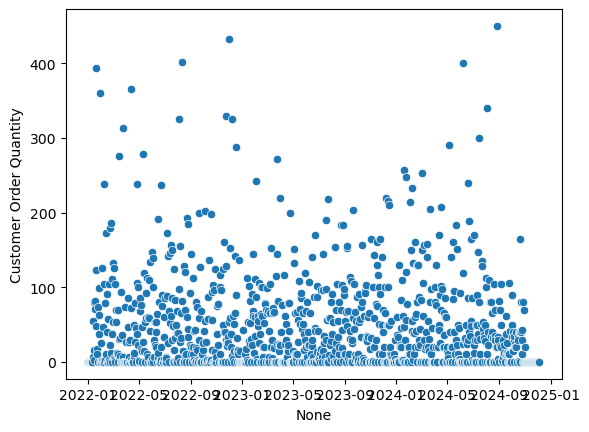

In [38]:
sns.scatterplot(x=daily_df.index, y=daily_df['Customer Order Quantity'])

In [39]:
monthly_df

,Product ID,Product Name,Dispatched Quantity,Customer Order Quantity,ECG_DESP,TUAV,PIB_CO,ISE_CO,VTOTAL_19,OTOTAL_19,ICI
YearMonth,,,,,,,,,,,
2017-01-01,161032,Material_4,0.0,0.0,9.131904e+05,11303.0,14517.735830,100.730076,17178.0,133721.0,1.90
2017-02-01,161032,Material_4,0.0,0.0,1.007968e+06,16187.0,14517.735830,101.167441,16175.0,130854.0,-0.10
2017-03-01,161032,Material_4,0.0,0.0,1.083268e+06,15231.0,14517.735830,100.377762,15333.0,137551.0,-0.90
2017-04-01,161032,Material_4,0.0,0.0,9.000049e+05,14093.0,14985.508742,103.507894,14456.0,135700.0,-8.50
2017-05-01,161032,Material_4,0.0,0.0,9.990460e+05,13645.0,14985.508742,102.634285,14281.0,136432.0,-8.80
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,161032,Material_4,1455.0,1729.0,1.050528e+06,13092.0,10752.586638,74.110006,12248.0,165294.0,-1.19
2024-08-01,161032,Material_4,1372.0,1835.0,1.074200e+06,14486.0,10752.586638,74.788896,13963.0,166207.0,-1.42
2024-09-01,161032,Material_4,1850.0,712.0,1.003767e+06,17833.0,10752.586638,73.813056,10856.0,166496.0,1.34


## Prepare Features

In [40]:
def prepare_features(data, monthly_data, is_training=True):
    """
    Prepare features combining daily and monthly data.
    is_training: bool, if False will not use future data for feature creation
    """
    features = pd.DataFrame(index=data.index)
    
    # Basic demand lags - for test data, we need to be careful about the boundary
    for lag in [1, 2, 3, 7, 14, 30]:  # Removed longer lags that might leak across train/test boundary
        features[f'Demand_lag_{lag}d'] = data['Dispatched Quantity'].shift(lag)
    
    # Rolling statistics - using only past data
    for window in [7, 14, 30]:  # Reduced windows to avoid boundary issues
        roll = data['Dispatched Quantity'].rolling(window=window, min_periods=1, closed='left')
        features[f'Demand_roll_mean_{window}d'] = roll.mean()
        features[f'Demand_roll_std_{window}d'] = roll.std()
    
    # External variables - careful with monthly data
    external_vars = ['ECG_DESP', 'TUAV', 'PIB_CO', 'ISE_CO', 'VTOTAL_19', 'OTOTAL_19', 'ICI']
    for var in external_vars:
        if var in monthly_data.columns:
            # Monthly lags - only use data from before current month
            for lag in range(1, 4):  # Reduced lag range to avoid leakage
                lagged = monthly_data[var].shift(lag)
                # For test data, we need to ensure we're not using future information
                if not is_training:
                    lagged = lagged.shift(1)  # Extra shift for test to ensure we only use known data
                features[f'{var}_lag_{lag}m'] = lagged.reindex(data.index).fillna(method='ffill', limit=30)
    
    # Seasonality features - these are safe as they're based on the date
    features['Month'] = data.index.month
    features['Quarter'] = data.index.quarter
    features['WeekOfYear'] = data.index.isocalendar().week
    features['DayOfWeek'] = data.index.dayofweek
    features['DayOfMonth'] = data.index.day
    
    # Cyclical encoding - also safe as they're based on the date
    features['Month_sin'] = np.sin(2 * np.pi * data.index.month / 12)
    features['Month_cos'] = np.cos(2 * np.pi * data.index.month / 12)
    features['Day_sin'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    features['Day_cos'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    
    # Customer order features - only use recent lags
    for lag in [1, 2, 3, 7, 14]:
        features[f'Customer_Order_Lag{lag}'] = data['Customer Order Quantity'].shift(lag)
        if lag <= 7:  # Only compute ratios for short lags to avoid division issues
            ratio = (data['Customer Order Quantity'].shift(lag) / 
                    data['Dispatched Quantity'].shift(lag))
            features[f'Order_Demand_Ratio_Lag{lag}'] = ratio.replace([np.inf, -np.inf], np.nan)
    
    return features.fillna(0)

# Split data based on date first
train_cutoff = pd.to_datetime('2024-06-01')
train_mask = daily_df.index < train_cutoff

train_data = daily_df[train_mask].copy()
test_data = daily_df[~train_mask].copy()

# Split monthly data using the same cutoff
monthly_train_mask = monthly_df.index < train_cutoff
monthly_train_data = monthly_df[monthly_train_mask].copy()
monthly_test_data = monthly_df[~monthly_train_mask].copy()

# Create validation set from last month of training data
val_cutoff = train_cutoff - pd.DateOffset(months=1)
val_mask = (daily_df.index >= val_cutoff) & (daily_df.index < train_cutoff)
val_data = daily_df[val_mask].copy()
train_data = daily_df[daily_df.index < val_cutoff].copy()

# Split monthly data for validation
monthly_val_data = monthly_df[(monthly_df.index >= val_cutoff) & (monthly_df.index < train_cutoff)].copy()
monthly_train_data = monthly_df[monthly_df.index < val_cutoff].copy()

# Prepare features
X_train = prepare_features(train_data, monthly_train_data, is_training=True)
y_train = train_data['Dispatched Quantity']

X_val = prepare_features(val_data, monthly_val_data, is_training=False)
y_val = val_data['Dispatched Quantity']

X_test = prepare_features(test_data, monthly_test_data, is_training=False)
y_test = test_data['Dispatched Quantity']

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Training data shape: (851, 51)
Validation data shape: (31, 51)
Test data shape: (188, 51)


C:\Users\k_pow\AppData\Local\Temp\ipykernel_18360\3335945644.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features[f'{var}_lag_{lag}m'] = lagged.reindex(data.index).fillna(method='ffill', limit=30)
C:\Users\k_pow\AppData\Local\Temp\ipykernel_18360\3335945644.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features[f'{var}_lag_{lag}m'] = lagged.reindex(data.index).fillna(method='ffill', limit=30)
C:\Users\k_pow\AppData\Local\Temp\ipykernel_18360\3335945644.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features[f'{var}_lag_{lag}m'] = lagged.reindex(data.index).fillna(method='ffill', limit=30)
C:\Users\k_pow\AppData\Local\Temp\ipykernel_18360\3335945644.py:28: FutureWarning: Series.fillna with 'method' is d

## Split Data and Train Model

In [41]:
# Train XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],  # Use validation set instead of test set
    verbose=False
)

print("Model training completed")

Model training completed


## Evaluate Model at Multiple Time Scales

In [42]:
# Make daily predictions
daily_pred = model.predict(X_test)

# Create daily results DataFrame for daily predictions
daily_results = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Predicted': daily_pred
})

# Export daily results to CSV
output_path = 'daily_predictions_vs_actual.csv'
daily_results.to_csv(output_path, index=False)
print(f"\nExported daily predictions vs actuals to: {output_path}")

# Filter for actual test period
test_start = pd.Timestamp('2024-06-01')  # Changed from July 1st to June 1st
test_end = pd.Timestamp('2024-12-05')
daily_results = daily_results[(daily_results['Date'] >= test_start) & (daily_results['Date'] <= test_end)]

# Add month column for aggregation
daily_results['Year'] = daily_results['Date'].dt.year
daily_results['Month'] = daily_results['Date'].dt.month

# Aggregate to monthly using groupby (this should match Excel's behavior)
monthly_results = daily_results.groupby(['Year', 'Month']).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Create proper datetime for the first of each month
monthly_results['Date'] = pd.to_datetime(monthly_results[['Year', 'Month']].assign(Day=1))

# Sort by date
monthly_results = monthly_results.sort_values('Date')

# Print the monthly totals for verification
print("\nMonthly Totals:")
print(monthly_results[['Date', 'Actual', 'Predicted']].to_string())

# Aggregate to weekly
weekly_df = daily_results.copy()
weekly_df.set_index('Date', inplace=True)
weekly_results = weekly_df.resample('W-MON').sum()
weekly_results = weekly_results.loc[test_start:test_end]
weekly_results = weekly_results.reset_index()

print("\nAggregation Info:")
print(f"Daily predictions: {len(daily_results)} days")
print(f"Weeks: {len(weekly_results)} weeks")
print(f"Months: {len(monthly_results)} months")

# Calculate metrics for each time scale
def calculate_metrics(actual, pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, pred)),
        'MAE': mean_absolute_error(actual, pred),
        'R2': r2_score(actual, pred)
    }

# Calculate metrics for daily, weekly, and monthly
daily_metrics = calculate_metrics(daily_results['Actual'], daily_results['Predicted'])
weekly_metrics = calculate_metrics(weekly_results['Actual'], weekly_results['Predicted'])
monthly_metrics = calculate_metrics(monthly_results['Actual'], monthly_results['Predicted'])

# Debugging: Print actual vs predicted for daily results
print("\nDaily Actual vs Predicted:")
print(daily_results[['Actual', 'Predicted']].head(10))  # Print first 10 for inspection

# Additional Debugging: Print distribution of actual and predicted values
print("\nDistribution of Actual Values:")
print(daily_results['Actual'].describe())
print("\nDistribution of Predicted Values:")
print(daily_results['Predicted'].describe())

# Print metrics
print("\nModel Performance Metrics:")
print("\nDaily Metrics:")
print(f"RMSE: {daily_metrics['RMSE']:.2f}")
print(f"MAE: {daily_metrics['MAE']:.2f}")
print(f"R2: {daily_metrics['R2']:.3f}")

# Residuals analysis
residuals = daily_results['Actual'] - daily_results['Predicted']
print("\nResiduals Analysis:")
print(residuals.describe())

print("\nWeekly Metrics:")
print(f"RMSE: {weekly_metrics['RMSE']:.2f}")
print(f"MAE: {weekly_metrics['MAE']:.2f}")
print(f"R2: {weekly_metrics['R2']:.3f}")

print("\nMonthly Metrics:")
print(f"RMSE: {monthly_metrics['RMSE']:.2f}")
print(f"MAE: {monthly_metrics['MAE']:.2f}")
print(f"R2: {monthly_metrics['R2']:.3f}")


Exported daily predictions vs actuals to: daily_predictions_vs_actual.csv

Monthly Totals:
        Date  Actual    Predicted
0 2024-06-01    1543  1937.991699
1 2024-07-01    1455  1563.399536
2 2024-08-01    1372  1742.953857
3 2024-09-01    1850  1391.667480
4 2024-10-01     946  1270.101685
5 2024-11-01    1056  1446.695557
6 2024-12-01     322   273.226440

Aggregation Info:
Daily predictions: 188 days
Weeks: 27 weeks
Months: 7 months

Daily Actual vs Predicted:
            Actual   Predicted
2024-06-01       0   51.465504
2024-06-02     100   29.059971
2024-06-03       0   51.748470
2024-06-04      27   52.337547
2024-06-05      30   46.781246
2024-06-06       0   60.466240
2024-06-07     153   76.975861
2024-06-08      49  127.340744
2024-06-09       0   61.446918
2024-06-10       0   43.237980

Distribution of Actual Values:
count    188.000000
mean      45.446809
std       67.486757
min        0.000000
25%        0.000000
50%       20.000000
75%       70.000000
max      432.00

## Visualize Predictions at Different Time Scales

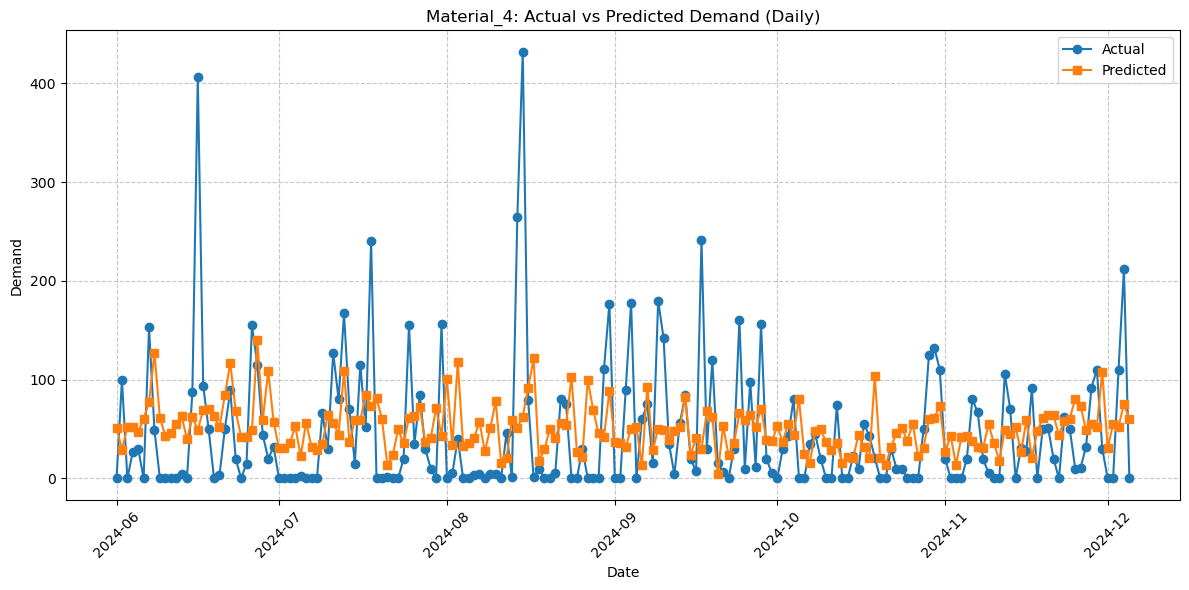


Daily Results:
Date range: 2024-06-01 00:00:00 to 2024-12-05 00:00:00
                 Date  Actual   Predicted
2024-06-01 2024-06-01       0   51.465504
2024-06-02 2024-06-02     100   29.059971
2024-06-03 2024-06-03       0   51.748470
2024-06-04 2024-06-04      27   52.337547
2024-06-05 2024-06-05      30   46.781246
2024-06-06 2024-06-06       0   60.466240
2024-06-07 2024-06-07     153   76.975861
2024-06-08 2024-06-08      49  127.340744
2024-06-09 2024-06-09       0   61.446918
2024-06-10 2024-06-10       0   43.237980
2024-06-11 2024-06-11       0   45.614594
2024-06-12 2024-06-12       0   55.456203
2024-06-13 2024-06-13       4   63.337807
2024-06-14 2024-06-14       0   39.513496
2024-06-15 2024-06-15      87   62.051540
2024-06-16 2024-06-16     406   49.005390
2024-06-17 2024-06-17      94   69.247726
2024-06-18 2024-06-18      50   70.671867
2024-06-19 2024-06-19       0   63.552490
2024-06-20 2024-06-20       3   51.771454
2024-06-21 2024-06-21      50   84.089371
2024-

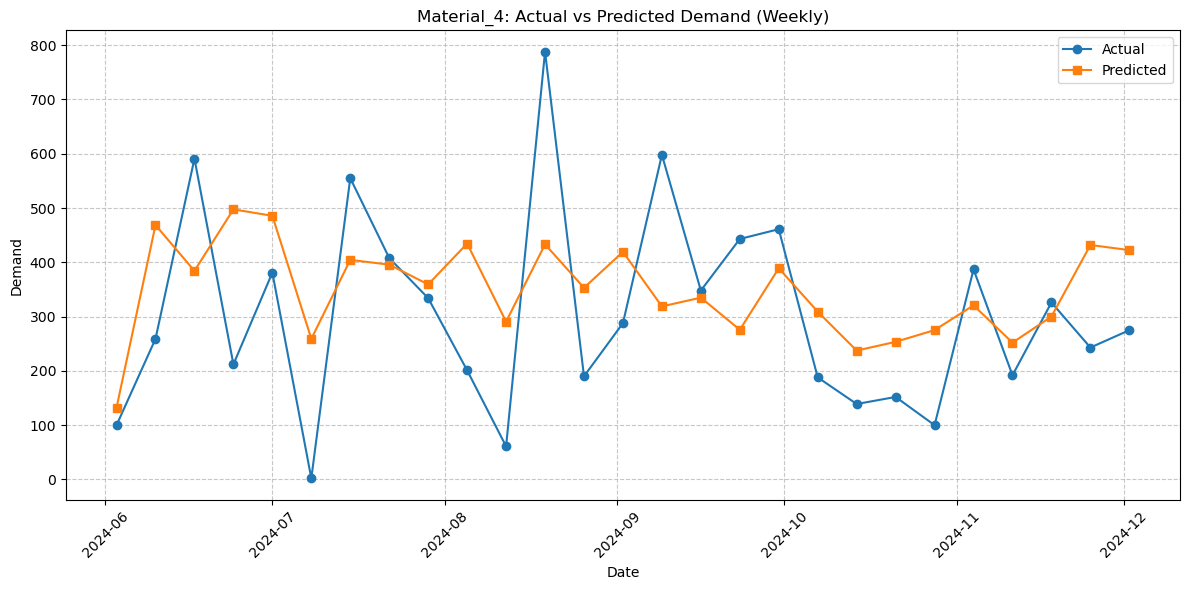


Weekly Results:
Date range: 2024-06-03 00:00:00 to 2024-12-02 00:00:00
         Date  Actual   Predicted
0  2024-06-03     100  132.273941
1  2024-06-10     259  468.586548
2  2024-06-17     591  384.226746
3  2024-06-24     212  497.537231
4  2024-07-01     381  485.657501
5  2024-07-08       2  259.066071
6  2024-07-15     555  404.502747
7  2024-07-22     408  395.715790
8  2024-07-29     334  359.274689
9  2024-08-05     201  434.531219
10 2024-08-12      61  290.714050
11 2024-08-19     788  433.072937
12 2024-08-26     190  353.089661
13 2024-09-02     288  419.228302
14 2024-09-09     598  318.764526
15 2024-09-16     348  334.938354
16 2024-09-23     443  275.736694
17 2024-09-30     461  389.095490
18 2024-10-07     188  309.066406
19 2024-10-14     139  237.401352
20 2024-10-21     152  253.514862
21 2024-10-28     100  275.149780
22 2024-11-04     387  320.701965
23 2024-11-11     192  252.026184
24 2024-11-18     326  300.129059
25 2024-11-25     243  431.854614
26 2024-12

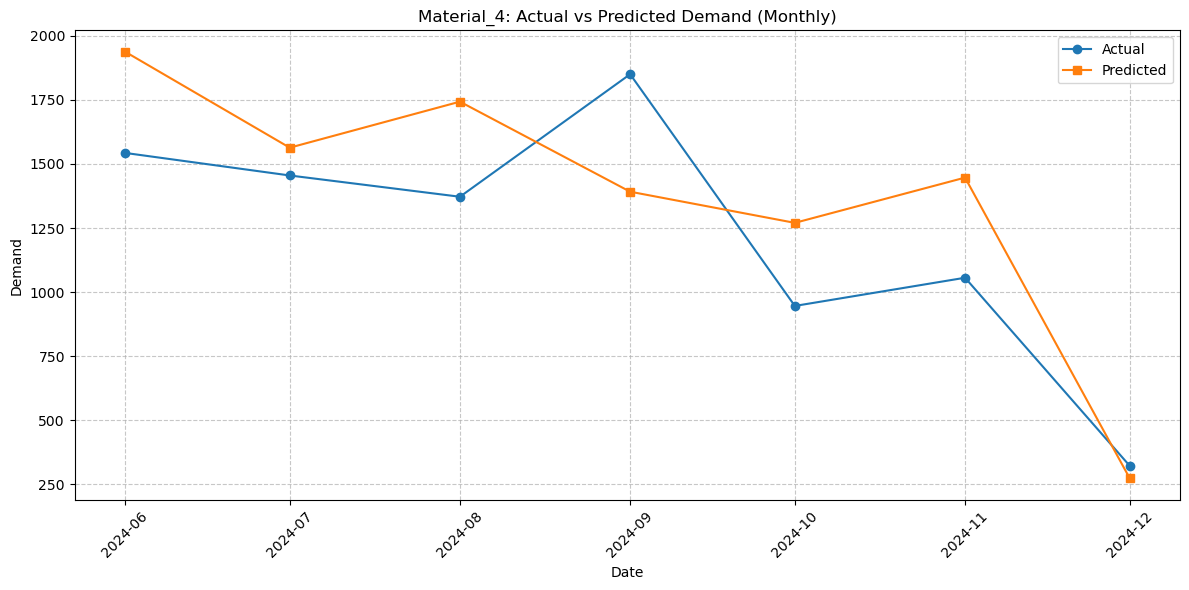


Monthly Results:
Date range: 2024-06-01 00:00:00 to 2024-12-01 00:00:00
        Date  Actual    Predicted
0 2024-06-01    1543  1937.991699
1 2024-07-01    1455  1563.399536
2 2024-08-01    1372  1742.953857
3 2024-09-01    1850  1391.667480
4 2024-10-01     946  1270.101685
5 2024-11-01    1056  1446.695557
6 2024-12-01     322   273.226440


In [43]:
def plot_predictions(results, title, freq):
    plt.figure(figsize=(12, 6))
    plt.plot(results['Date'], results['Actual'], label='Actual', marker='o')
    plt.plot(results['Date'], results['Predicted'], label='Predicted', marker='s')
    plt.title(f'{material_no}: Actual vs Predicted Demand ({freq})')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    
    # Just rotate the existing dates for readability
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Print actual dates and values
    print(f"\n{freq} Results:")
    print("Date range:", results['Date'].min(), "to", results['Date'].max())
    print(results[['Date', 'Actual', 'Predicted']].to_string())

# Plot results at different time scales
plot_predictions(daily_results, 'Daily Predictions', 'Daily')
plot_predictions(weekly_results, 'Weekly Predictions', 'Weekly')
plot_predictions(monthly_results, 'Monthly Predictions', 'Monthly')

## Analyze Residuals

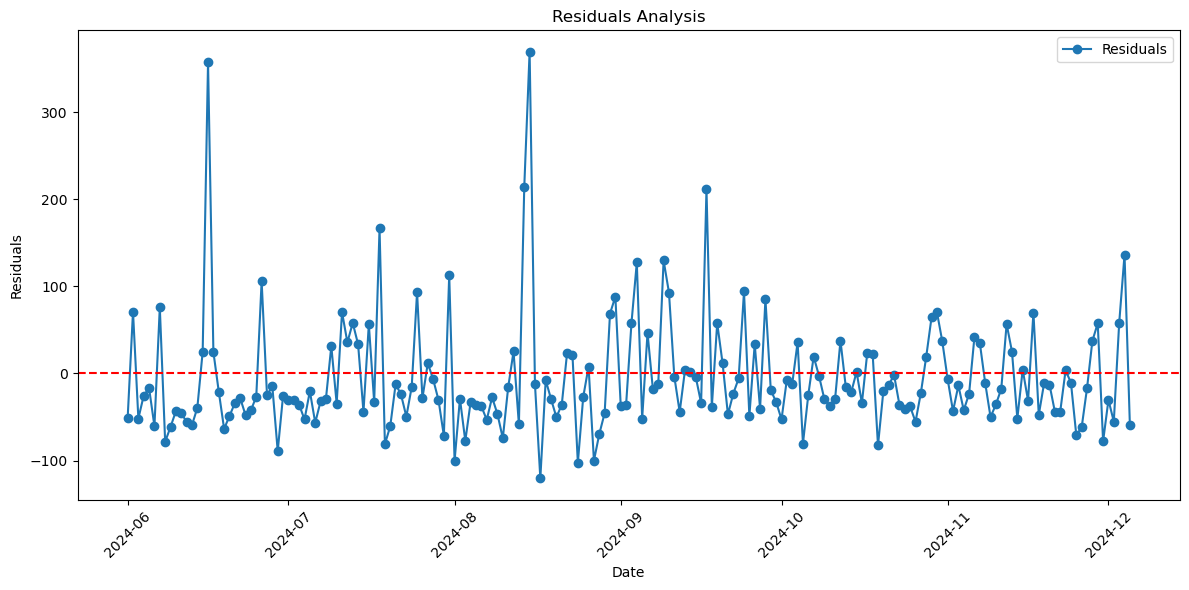

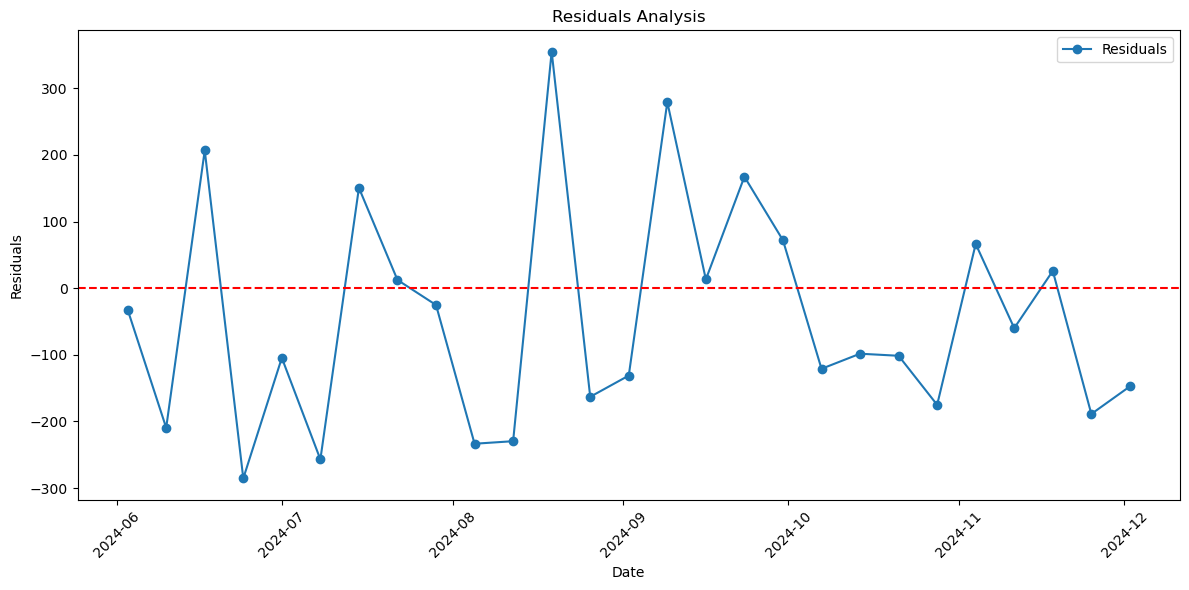

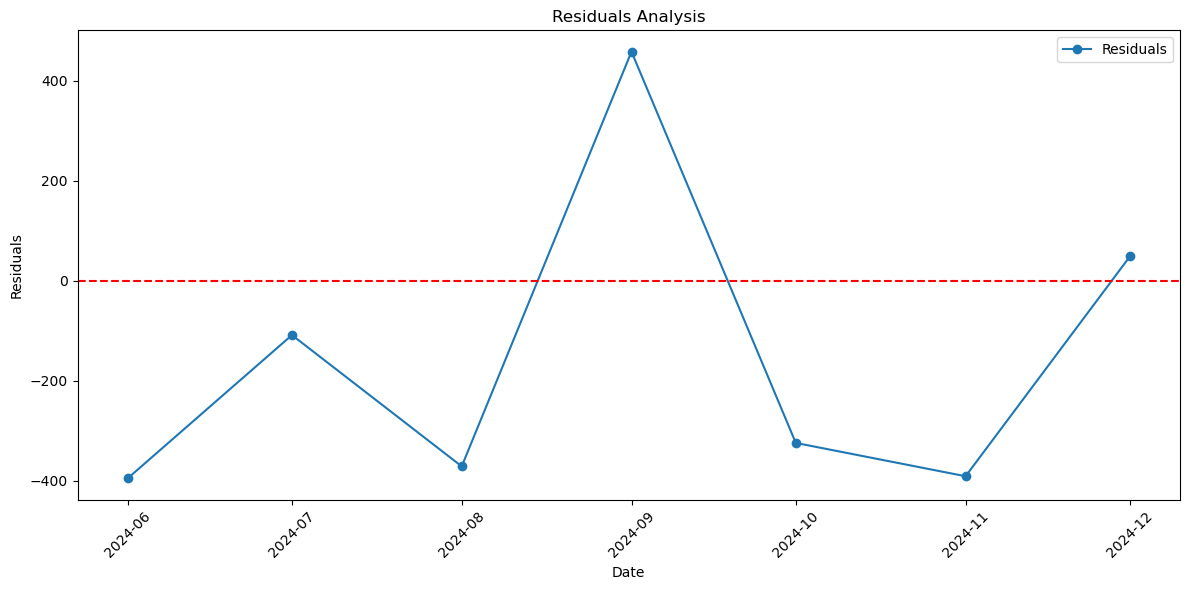

In [44]:
def analyze_residuals(results):
    residuals = results['Actual'] - results['Predicted']
    plt.figure(figsize=(12, 6))
    plt.plot(results['Date'], residuals, label='Residuals', marker='o')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals Analysis')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Analyze residuals for each time scale
analyze_residuals(daily_results)
analyze_residuals(weekly_results)
analyze_residuals(monthly_results)

## Simplify the Model (Optional)


Simpler Model Daily Metrics:
RMSE: 67.02
MAE: 45.74
R2: 0.008


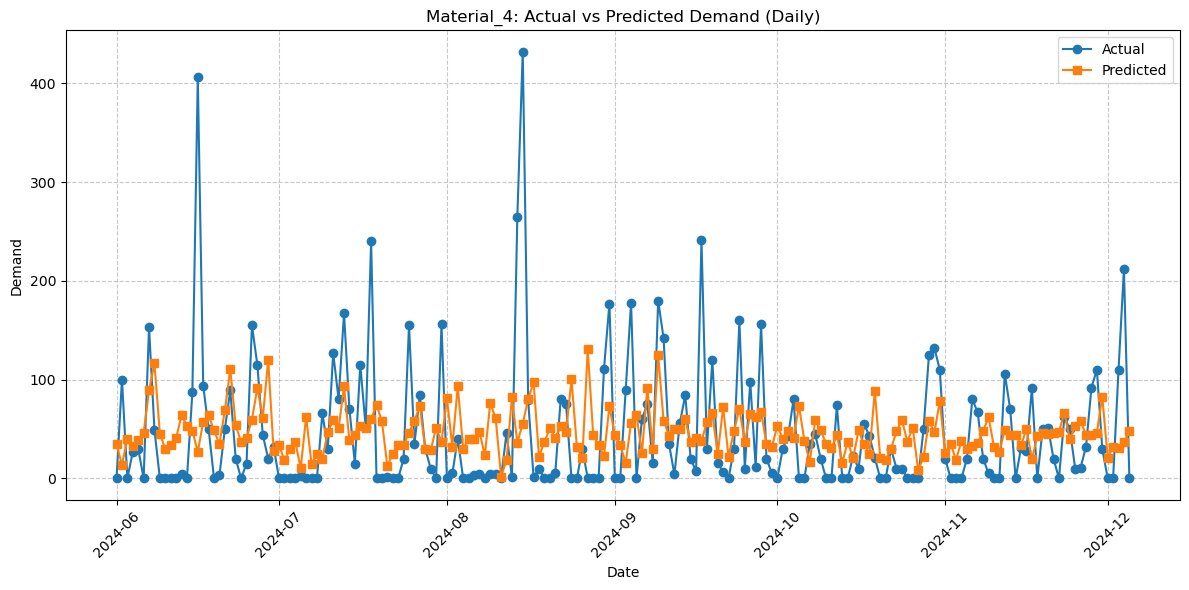


Daily Results:
Date range: 2024-06-01 00:00:00 to 2024-12-05 00:00:00
                 Date  Actual   Predicted
2024-06-01 2024-06-01       0   35.024597
2024-06-02 2024-06-02     100   13.526751
2024-06-03 2024-06-03       0   40.231644
2024-06-04 2024-06-04      27   33.106850
2024-06-05 2024-06-05      30   39.313763
2024-06-06 2024-06-06       0   45.861626
2024-06-07 2024-06-07     153   88.987335
2024-06-08 2024-06-08      49  116.740677
2024-06-09 2024-06-09       0   45.135628
2024-06-10 2024-06-10       0   29.662535
2024-06-11 2024-06-11       0   33.362797
2024-06-12 2024-06-12       0   40.547916
2024-06-13 2024-06-13       4   63.877556
2024-06-14 2024-06-14       0   53.275185
2024-06-15 2024-06-15      87   48.410416
2024-06-16 2024-06-16     406   26.739540
2024-06-17 2024-06-17      94   57.448879
2024-06-18 2024-06-18      50   63.737938
2024-06-19 2024-06-19       0   48.536510
2024-06-20 2024-06-20       3   34.708942
2024-06-21 2024-06-21      50   68.970901
2024-

In [45]:
# Train a simpler XGBoost model
simple_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=50,  # Reduced number of estimators
    learning_rate=0.1,  # Adjusted learning rate
    max_depth=3,  # Reduced max depth
    min_child_weight=1,  # Adjusted min child weight
    subsample=0.9,  # Adjusted subsample
    colsample_bytree=0.9,  # Adjusted colsample
    random_state=42
)

# Train the simpler model
simple_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],  # Use validation set instead of test set
    verbose=False
)

# Make predictions with the simpler model
simple_daily_pred = simple_model.predict(X_test)

# Create DataFrames with actual and predicted values for the simpler model
simple_daily_results = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Predicted': simple_daily_pred
})

# Filter for actual test period
test_start = pd.Timestamp('2024-06-01')  # Changed from July 1st to June 1st
test_end = pd.Timestamp('2024-12-05')
simple_daily_results = simple_daily_results[(simple_daily_results['Date'] >= test_start) & (simple_daily_results['Date'] <= test_end)]

# Calculate metrics for the simpler model
simple_daily_metrics = calculate_metrics(simple_daily_results['Actual'], simple_daily_results['Predicted'])

print("\nSimpler Model Daily Metrics:")
print(f"RMSE: {simple_daily_metrics['RMSE']:.2f}")
print(f"MAE: {simple_daily_metrics['MAE']:.2f}")
print(f"R2: {simple_daily_metrics['R2']:.3f}")

# Plot predictions for the simpler model
plot_predictions(simple_daily_results, 'Daily Predictions (Simpler Model)', 'Daily')

## Feature Importance Analysis

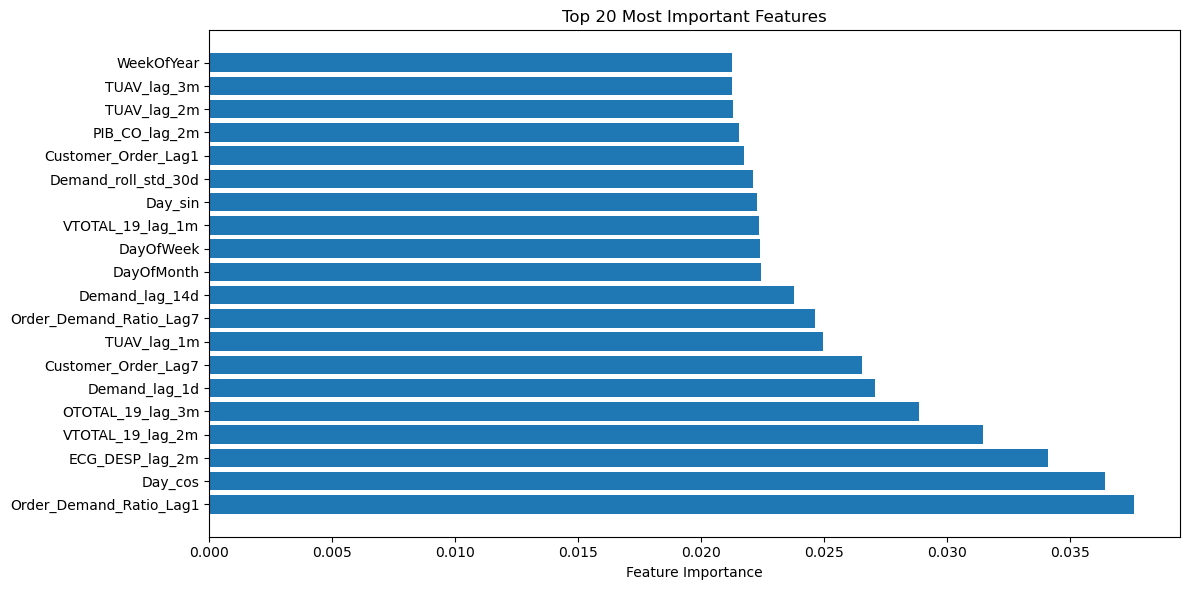


Top 10 Most Important Features:
                    feature  importance
43  Order_Demand_Ratio_Lag1    0.037593
41                  Day_cos    0.036406
13          ECG_DESP_lag_2m    0.034102
25         VTOTAL_19_lag_2m    0.031455
29         OTOTAL_19_lag_3m    0.028866
0             Demand_lag_1d    0.027072
48      Customer_Order_Lag7    0.026521
15              TUAV_lag_1m    0.024972
49  Order_Demand_Ratio_Lag7    0.024627
4            Demand_lag_14d    0.023758


In [46]:
# Get feature importance
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 6))
plt.barh(importance.head(20)['feature'], importance.head(20)['importance'])
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance.head(10))